In [24]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

In [10]:
# Global parameters

radius_range = np.arange(0.5,1.6,0.5)

with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)

point_collection_indices = np.arange(len(new_contiguous_point_collection))
point_collection_indices

array([0, 1, 2, 3, 4, 5, 6])

# Step 1 Getting sample points for one-time partial radius

Done generating 1000 samples in 0.123 seconds.


(array([153., 138., 141., 137., 136., 150., 145.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

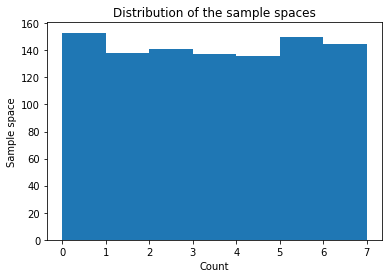

In [22]:
samples = 1000

sample_points = []

samples_indeces = []

t0 = time.time()

for i in np.arange(samples):

    random_object = np.random.choice(point_collection_indices)

    object_name = new_contiguous_point_collection[random_object][0]
    pointCloud = new_contiguous_point_collection[random_object][1]
    triangles = new_contiguous_point_collection[random_object][2]
    
    triangle_index = np.random.choice(np.arange(len(triangles)))
    vertex_index = triangles[triangle_index,1]
    original_vertex = pointCloud[vertex_index]

    sample_points.append([
        random_object, 
        object_name, 
        original_vertex
    ])
    
    samples_indeces.append(random_object)
    
print("Done generating",len(sample_points),"samples in {:.3f} seconds.".format(time.time()-t0))

with open('sample_points.pickle','wb') as f:
    pickle.dump(sample_points,f)
    
plt.title("Distribution of the sample spaces")
plt.xlabel("Count")
plt.ylabel("Sample space")
plt.hist(samples_indeces,bins = np.arange(0,8))


# Step 2 Creating a synthetic set of successive partial spaces

Similar to the partial case above, we use the same sample points, i.e. centroids, for successive releases but will only vary the size of the partial space for every release.


In [26]:

samples = 100
releases = 100

nearby_range = 2.0
    
t1 = time.time()

successive_sample_points = []

for i in np.arange(samples):#

    random_object = np.random.choice(point_collection_indices)
    #reference_ransac = np.random.randint(5)

    object_name = new_contiguous_point_collection[random_object][0]
    pointCloud = new_contiguous_point_collection[random_object][1]
    triangles = new_contiguous_point_collection[random_object][2]

    current_vertex = pointCloud[np.random.randint(len(pointCloud))]

    growing_point_collection_vertices = [[
        random_object, 
        object_name, 
        current_vertex
    ]]

    nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud)),algorithm='kd_tree').fit(pointCloud[:,:3])

    for release in np.arange(releases-1):

        distances, indices = nbrs.kneighbors([current_vertex[:3]])

        cand_indices = indices[0,np.where(distances[0]<(nearby_range))[0]]

        distribution = np.sort(abs(np.random.normal(nearby_range*0.5,nearby_range*0.3,len(cand_indices))))

        current_vertex = pointCloud[
            np.random.choice(
                cand_indices,
                p = distribution/np.sum(distribution)
            )
        ]

        growing_point_collection_vertices.append([
            random_object, 
            object_name, 
            current_vertex
        ])

    successive_sample_points.append([
        [random_object, object_name],
        growing_point_collection_vertices
    ])

    if i % 33 == 1:
        print(" Done with successive {} sample_points extraction in {:.3f} seconds".format(i,time.time()-t1))
        t1 = time.time()

    with open('successive_sample_points.pickle','wb') as f:
        pickle.dump(successive_sample_points,f)


 Done with successive 1 sample_points extraction for radius 0.5 in 1.080 seconds
 Done with successive 34 sample_points extraction for radius 0.5 in 18.763 seconds
 Done with successive 67 sample_points extraction for radius 0.5 in 18.948 seconds


In [29]:

t1 = time.time()

try:
    with open('successive_sample_points.pickle','rb') as f:
        successive_point_collection = pickle.load(f)

    samples = len(successive_point_collection)
    releases = len(successive_point_collection[0][1])

    print(samples,"samples for radius",radius)
    print(releases,"releases each")

except Exception as e1:
    print(e1)

successive_sample_points_per_release = [[]]

for k, [obj_, growing_point_collection] in enumerate(successive_point_collection):

    t2 = time.time()

    successive_sample_points = []

    reference_ransac = np.random.randint(5)

    for i, obj_meta in enumerate(growing_point_collection):

        successive_sample_points.append([obj_meta, reference_ransac])

        try:
            successive_sample_points_per_release[i].append(successive_sample_points)
        except:
            successive_sample_points_per_release.append([successive_sample_points])

        #print(len(successive_sample_points_per_release[i]),len(successive_sample_points_per_release[i][k]))

    with open('successive_sample_points_per_release.pickle','wb') as f:
        pickle.dump(successive_sample_points_per_release,f)

print(" Done with successive sample_points extraction in {:.3f} seconds".format(time.time()-t1))
    

100 samples for radius 0.5
100 releases each
 Done with successive sample_points extraction in 2.226 seconds


# Step 3: Create submaps for pointnetvlad using same partial samples